Note: The model used here is the modified version used in: http://docs.pymc.io/notebooks/probabilistic_matrix_factorization.html

This is the same model, only difference is that it is applied to a more sparse dataset named MovieLens dataset.

In [38]:
% matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil
import pymc3 as pm
DATA_DIR = './ml-1m'

import seaborn as sns
plt.style.use('seaborn')
sns.set_context("poster", font_scale=1.2)

data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'), sep='::', usecols=[0,1,2])
data.tail()

def dropNanRowsAndCols(data, test):
    rowsToDrop = []
    colsToDrop = []
    
    newData = np.array(data, copy=True)
    newTest = np.array(test, copy=True)

    for i in range(newData.shape[0]):
        if all(np.isnan(newData[i,:])):
            rowsToDrop.append(i)
            
    newData = np.delete(newData, rowsToDrop, axis=0)
    
    for i in range(newData.shape[1]):
        if all(np.isnan(newData[:,i])):
            colsToDrop.append(i)

    newData = np.delete(newData, colsToDrop, axis=1)
    
    newTest = np.delete(newTest, rowsToDrop, axis=0)
    newTest = np.delete(newTest, colsToDrop, axis=1)
    
    print(str(len(rowsToDrop)) + " rows and " + str(len(colsToDrop)) + " cols are dropped")
    return newData, newTest

/home/uras/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [39]:
users = np.max(data.values[:,0])
movies = np.max(data.values[:,1])

ratings = np.zeros((users, movies), dtype=float)

ratings[data.values[:,0]-1, data.values[:,1]-1] = data.values[:,2]
    
ratings[ratings == 0] = np.nan



In [40]:
N = 250

# find top N users with most ratings
users = np.array(data.values[:, 0])
unique, counts = np.unique(users, return_counts=True)
userRatingCounts = dict(zip(unique, counts))

sortedURC = sorted(userRatingCounts, key=userRatingCounts.get, reverse=True)
topUsers = sortedURC[:N]

# find top N movies which are the most rated
movies = np.array(data.values[:, 1])
unique, counts = np.unique(movies, return_counts=True)
movieRatingCounts = dict(zip(unique, counts))

sortedMRC = sorted(movieRatingCounts, key=movieRatingCounts.get, reverse=True)
topMovies = sortedMRC[:N]

subRatings = np.zeros((len(topUsers), len(topMovies)), dtype=float)

for i in range(N):
    for j in range(N):
        subRatings[i, j] = ratings[topUsers[i]-1, topMovies[j]-1]
        
rowsToDrop = []
colsToDrop = []

for i in range(N):
    if all(np.isnan(subRatings[i,:])):
        rowsToDrop.append(i)
    if all(np.isnan(subRatings[:,i])):
        colsToDrop.append(i)
    
subRatings = np.delete(subRatings, rowsToDrop, axis=0)
subRatings = np.delete(subRatings, colsToDrop, axis=1)

print(subRatings.shape)
print(np.isnan(subRatings).sum())

#subRatings = np.delete(subRatings, 48, axis=0)

(250, 250)
15988


In [41]:
from collections import OrderedDict

# Create a base class with scaffolding for our 3 baselines.

def split_title(title):
    """Change "BaselineMethod" to "Baseline Method"."""
    words = []
    tmp = [title[0]]
    for c in title[1:]:
        if c.isupper():
            words.append(''.join(tmp))
            tmp = [c]
        else:
            tmp.append(c)
    words.append(''.join(tmp))
    return ' '.join(words)


class Baseline(object):
    """Calculate baseline predictions."""

    def __init__(self, train_data):
        """Simple heuristic-based transductive learning to fill in missing
        values in data matrix."""
        self.predict(train_data.copy())

    def predict(self, train_data):
        raise NotImplementedError(
            'baseline prediction not implemented for base class')

    def rmse(self, test_data):
        """Calculate root mean squared error for predictions on test data."""
        return rmse(test_data, self.predicted)

    def __str__(self):
        return split_title(self.__class__.__name__)



# Implement the 3 baselines.

class UniformRandomBaseline(Baseline):
    """Fill missing values with uniform random values."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        pmin, pmax = masked_train.min(), masked_train.max()
        N = nan_mask.sum()
        train_data[nan_mask] = np.random.uniform(pmin, pmax, N)
        self.predicted = train_data


class GlobalMeanBaseline(Baseline):
    """Fill in missing values using the global mean."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data


class MeanOfMeansBaseline(Baseline):
    """Fill in missing values using mean of user/item/global means."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        global_mean = masked_train.mean()
        user_means = masked_train.mean(axis=1)
        item_means = masked_train.mean(axis=0)
        self.predicted = train_data.copy()
        n, m = train_data.shape
        for i in range(n):
            for j in range(m):
                if np.ma.isMA(item_means[j]):
                    self.predicted[i,j] = np.mean(
                        (global_mean, user_means[i]))
                else:
                    self.predicted[i,j] = np.mean(
                        (global_mean, user_means[i], item_means[j]))


baseline_methods = OrderedDict()
baseline_methods['ur'] = UniformRandomBaseline
baseline_methods['gm'] = GlobalMeanBaseline
baseline_methods['mom'] = MeanOfMeansBaseline

In [42]:
import time
import logging
import theano
import scipy as sp


# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
theano.config.compute_test_value = 'ignore'

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF(object):
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(-10, 10)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info('building the PMF model')
        with pm.Model() as pmf:
            U = pm.MvNormal(
                'U', mu=0, tau=self.alpha_u * np.eye(dim),
                shape=(n, dim), testval=np.random.randn(n, dim) * std)
            V = pm.MvNormal(
                'V', mu=0, tau=self.alpha_v * np.eye(dim),
                shape=(m, dim), testval=np.random.randn(m, dim) * std)
            R = pm.Normal(
                'R', mu=theano.tensor.dot(U, V.T), tau=self.alpha * np.ones((n, m)),
                observed=self.data)

        logging.info('done building the PMF model')
        self.model = pmf

    def __str__(self):
        return self.name

In [43]:
try:
    import ujson as json
except ImportError:
    import json


# First define functions to save our MAP estimate after it is found.
# We adapt these from `pymc3`'s `backends` module, where the original
# code is used to save the traces from MCMC samples.
def save_np_vars(vars, savedir):
    """Save a dictionary of numpy variables to `savedir`. We assume
    the directory does not exist; an OSError will be raised if it does.
    """
    logging.info('writing numpy vars to directory: %s' % savedir)
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
    shapes = {}
    for varname in vars:
        data = vars[varname]
        var_file = os.path.join(savedir, varname + '.txt')
        np.savetxt(var_file, data.reshape(-1, data.size))
        shapes[varname] = data.shape

        ## Store shape information for reloading.
        shape_file = os.path.join(savedir, 'shapes.json')
        with open(shape_file, 'w') as sfh:
            json.dump(shapes, sfh)


def load_np_vars(savedir):
    """Load numpy variables saved with `save_np_vars`."""
    shape_file = os.path.join(savedir, 'shapes.json')
    with open(shape_file, 'r') as sfh:
        shapes = json.load(sfh)

    vars = {}
    for varname, shape in shapes.items():
        var_file = os.path.join(savedir, varname + '.txt')
        vars[varname] = np.loadtxt(var_file).reshape(shape)

    return vars


# Now define the MAP estimation infrastructure.
def _map_dir(self):
    basename = 'pmf-map-d%d' % self.dim
    return os.path.join(DATA_DIR, basename)

def _find_map(self):
    """Find mode of posterior using Powell optimization."""
    tstart = time.time()
    with self.model:
        logging.info('finding PMF MAP using Powell optimization...')
        self._map = pm.find_MAP()

    elapsed = int(time.time() - tstart)
    logging.info('found PMF MAP in %d seconds' % elapsed)

    # This is going to take a good deal of time to find, so let's save it.
    save_np_vars(self._map, self.map_dir)

def _load_map(self):
    self._map = load_np_vars(self.map_dir)

def _map(self):
    try:
        return self._map
    except:
        if os.path.isdir(self.map_dir):
            self.load_map()
        else:
            self.find_map()
        return self._map


# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.load_map = _load_map
PMF.map_dir = property(_map_dir)
PMF.map = property(_map)

# Draw MCMC samples.
def _trace_dir(self):
    basename = 'pmf-mcmc-d%d' % self.dim
    return os.path.join(DATA_DIR, basename)

def _draw_samples(self, nsamples=1000, njobs=2):
    # First make sure the trace_dir does not already exist.
    if os.path.isdir(self.trace_dir):
        shutil.rmtree(self.trace_dir)

    with self.model:
        logging.info('drawing %d samples using %d jobs' % (nsamples, njobs))
        backend = pm.backends.Text(self.trace_dir)
        logging.info('backing up trace to directory: %s' % self.trace_dir)
        self.trace = pm.sample(draws=nsamples, init='advi',
                               n_init=150000, njobs=njobs, trace=backend)

def _load_trace(self):
    with self.model:
        self.trace = pm.backends.text.load(self.trace_dir)


# Update our class with the sampling infrastructure.
PMF.trace_dir = property(_trace_dir)
PMF.draw_samples = _draw_samples
PMF.load_trace = _load_trace

In [44]:
def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.array([
        [np.random.normal(R[i,j], self.std) for j in range(m)]
        for i in range(n)
    ])

    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


PMF.predict = _predict

# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N                 # mean squared error
    return np.sqrt(mse)                        # RMSE

In [46]:
import hashlib
import random
random.seed(27)

# Define a function for splitting train/test data.
def split_train_test(data, percent_test=10):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape             # # users, # jokes
    N = n * m                     # # cells in matrix
    test_size = int(N / percent_test)  # use 10% of data as test set
    train_size = N - test_size    # and remainder for training

    # Prepare train/test ndarrays.
    train = np.array(data, copy=True)
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(data))       # ignore nan values in data
    idx_pairs = list(zip(tosample[0], tosample[1]))   # tuples of row/col index pairs
    indices = np.arange(len(idx_pairs))         # indices of index pairs
    sample = np.random.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan          # remove from train set

    # Verify everything worked properly
    # assert(np.isnan(train).sum() == test_size)
    # ssert(np.isnan(test).sum() == train_size)

    # Finally, hash the indices and save the train/test sets.
    index_string = ''.join(map(str, np.sort(sample)))
    name = hashlib.sha1(index_string.encode('utf-8')).hexdigest()
    savedir = os.path.join(DATA_DIR, name)
    save_np_vars({'train': train, 'test': test}, savedir)

    # Return train set, test set, and unique hash of indices.
    return train, test, name


def load_train_test(name):
    """Load the train/test sets."""
    savedir = os.path.join(DATA_DIR, name)
    vars = load_np_vars(savedir)
    return vars['train'], vars['test']

train, test, name = split_train_test(subRatings)

INFO:root:writing numpy vars to directory: ./ml-1m/da3321ca38535b491cddb91ed87fc4e3d954f08b


In [9]:
train, test = load_train_test('da3321ca38535b491cddb91ed87fc4e3d954f08b')

In [10]:
train, test = dropNanRowsAndCols(train, test)

0 rows and 257 cols are dropped


In [47]:
# Let's see the results:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print('%s RMSE:\t%.5f' % (method, baselines[name]))

Uniform Random Baseline RMSE:	1.73115
Global Mean Baseline RMSE:	1.02081
Mean Of Means Baseline RMSE:	0.94518


In [48]:
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each joke. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Jester dataset, this means we have D(1100), so for 5
# dimensions, we are sampling 5500 latent variables.
DIM = 5


pmf = PMF(train, DIM, ALPHA, std=0.05)

INFO:root:building the PMF model
INFO:root:done building the PMF model


In [49]:
# Find MAP for PMF.
pmf.find_map()

INFO:root:finding PMF MAP using Powell optimization...
logp = -69,263, ||grad|| = 1.9581: 100%|██████████| 178/178 [00:00<00:00, 557.84it/s]    
INFO:root:found PMF MAP in 1 seconds
INFO:root:writing numpy vars to directory: ./ml-1m/pmf-map-d5


In [50]:
def eval_map(pmf_model, train, test):
    U = pmf_model.map['U']
    V = pmf_model.map['V']

    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print('PMF MAP training RMSE: %.5f' % train_rmse)
    print('PMF MAP testing RMSE:  %.5f' % test_rmse)
    print('Train/test difference: %.5f' % overfit)

    return test_rmse


# Add eval function to PMF class.
PMF.eval_map = eval_map

In [51]:
# Evaluate PMF MAP estimates.
pmf_map_rmse = pmf.eval_map(train, test)
pmf_improvement = baselines['mom'] - pmf_map_rmse
print('PMF MAP Improvement:   %.5f' % pmf_improvement)

PMF MAP training RMSE: 1.07943
PMF MAP testing RMSE:  1.12574
Train/test difference: 0.04631
PMF MAP Improvement:   -0.18056


In [52]:
# Draw MCMC samples.
pmf.draw_samples(1000)

# uncomment to load previous trace rather than drawing new samples.
# pmf.load_trace()

INFO:root:drawing 1000 samples using 2 jobs
INFO:root:backing up trace to directory: ./ml-1m/pmf-mcmc-d5
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 83,825:  11%|█         | 16351/150000 [00:30<04:11, 530.96it/s]    
Convergence archived at 16400
INFO:pymc3.variational.inference:Convergence archived at 16400
Interrupted at 16,399 [10%]: Average Loss = 2.6492e+05
INFO:pymc3.variational.inference:Interrupted at 16,399 [10%]: Average Loss = 2.6492e+05
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [V, U]
INFO:pymc3:NUTS: [V, U]
100%|██████████| 1500/1500 [01:12<00:00, 20.78it/s]


In [60]:
def _norms(pmf_model, monitor=('U', 'V'), ord='fro'):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """
    monitor = ('U', 'V')
    norms = {var: [] for var in monitor}
    for sample in pmf_model.trace:
        for var in monitor:
            norms[var].append(np.linalg.norm(sample[var], ord))
    return norms


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    trace_norms = pmf_model.norms()
    u_series = pd.Series(trace_norms['U'])
    v_series = pd.Series(trace_norms['V'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    u_series.plot(kind='line', ax=ax1, grid=False,
                  title="$\|U\|_{Fro}^2$ at Each Sample")
    v_series.plot(kind='line', ax=ax2, grid=False,
                  title="$\|V\|_{Fro}^2$ at Each Sample")
    ax1.set_xlabel("Sample Number")
    ax2.set_xlabel("Sample Number")
    fig.savefig("traceplot2.png")


PMF.norms = _norms
PMF.traceplot = _traceplot

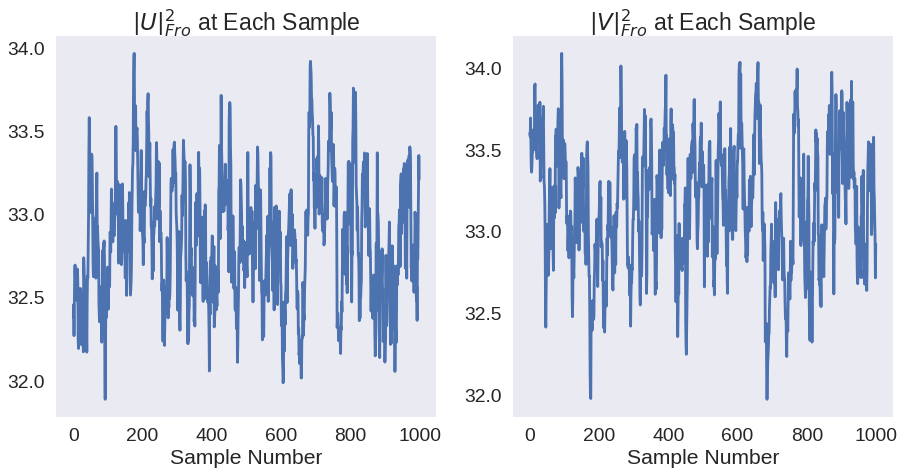

In [61]:
pmf.traceplot()

In [55]:
def _running_rmse(pmf_model, test_data, train_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence.
    """
    burn_in = burn_in if len(pmf_model.trace) >= burn_in else 0
    results = {'per-step-train': [], 'running-train': [],
               'per-step-test': [], 'running-test': []}
    R = np.zeros(test_data.shape)
    for cnt, sample in enumerate(pmf_model.trace[burn_in:]):
        sample_R = pmf_model.predict(sample['U'], sample['V'])
        R += sample_R
        running_R = R / (cnt + 1)
        results['per-step-train'].append(rmse(train_data, sample_R))
        results['running-train'].append(rmse(train_data, running_R))
        results['per-step-test'].append(rmse(test_data, sample_R))
        results['running-test'].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)
    
    #reconstructed = np.zeros(test_data.shape)
    #for cnt, sample in enumerate(pmf_model.trace[burn_in:]):
    #    sample_R = pmf_model.predict(sample['U'], sample['V'])

    # Return the final predictions, and the RMSE calculations
    return running_R, results#, reconstructed


PMF.running_rmse = _running_rmse

In [56]:
predicted, results = pmf.running_rmse(test, train, burn_in=300)

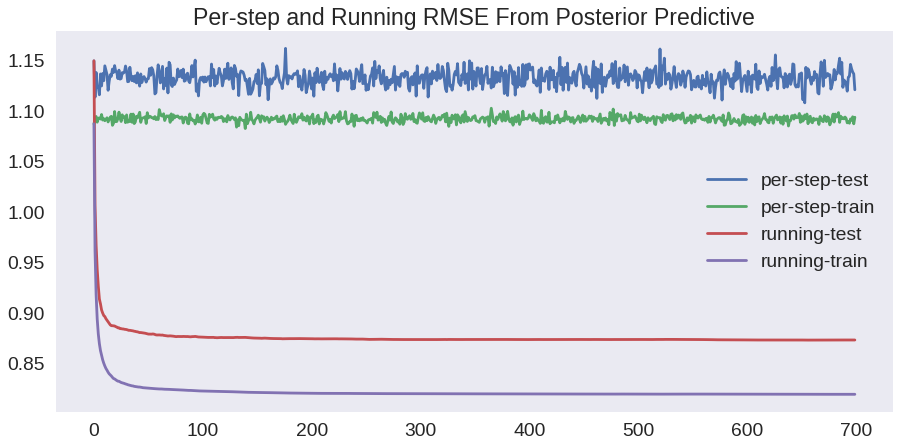

In [57]:
plot = results.plot(
            kind='line', grid=False, figsize=(15, 7),
            title='Per-step and Running RMSE From Posterior Predictive')
fig = plot.get_figure()
fig.savefig(os.path.join(DATA_DIR, 'running_rmse2.png'))

In [58]:
# U = np.array(pmf.trace['U'])
# V = np.array(pmf.trace['V'])
# print(np.matmul(U[500,:,:], V[500, :, :].transpose()))
# And our final RMSE?
final_test_rmse = results['running-test'].values[-1]
final_train_rmse = results['running-train'].values[-1]
print('Posterior predictive train RMSE: %.5f' % final_train_rmse)
print('Posterior predictive test RMSE:  %.5f' % final_test_rmse)
print('Train/test difference:           %.5f' % (final_test_rmse - final_train_rmse))
print('Improvement from MAP:            %.5f' % (pmf_map_rmse - final_test_rmse))
print('Improvement from Mean of Means:  %.5f' % (baselines['mom'] - final_test_rmse))

Posterior predictive train RMSE: 0.81975
Posterior predictive test RMSE:  0.87345
Train/test difference:           0.05371
Improvement from MAP:            0.25229
Improvement from Mean of Means:  0.07173


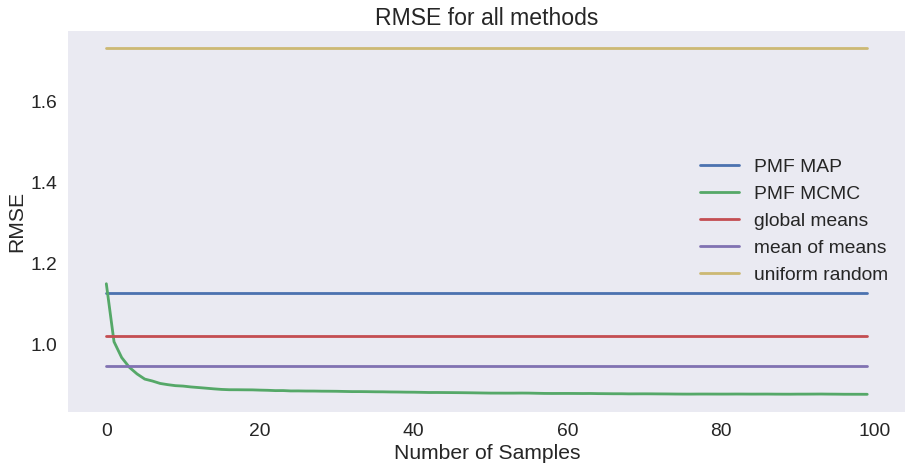

In [59]:
size = 100  # RMSE doesn't really change after 100th sample anyway.
all_results = pd.DataFrame({
    'uniform random': np.repeat(baselines['ur'], size),
    'global means': np.repeat(baselines['gm'], size),
    'mean of means': np.repeat(baselines['mom'], size),
    'PMF MAP': np.repeat(pmf_map_rmse, size),
    'PMF MCMC': results['running-test'][:size],
})
fig, ax = plt.subplots(figsize=(15, 7))
all_results.plot(kind='line', grid=False, ax=ax,
                 title='RMSE for all methods')
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE")
plt.savefig(os.path.join(DATA_DIR, 'RMSEall2.png'))